In [1]:
!pip install lazypredict

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import keras.backend as K

from lazypredict.Supervised import LazyClassifier


/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv').copy()
test = pd.read_csv('/kaggle/input/titanic/test.csv').copy()

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [4]:
train.shape

(891, 12)

In [5]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

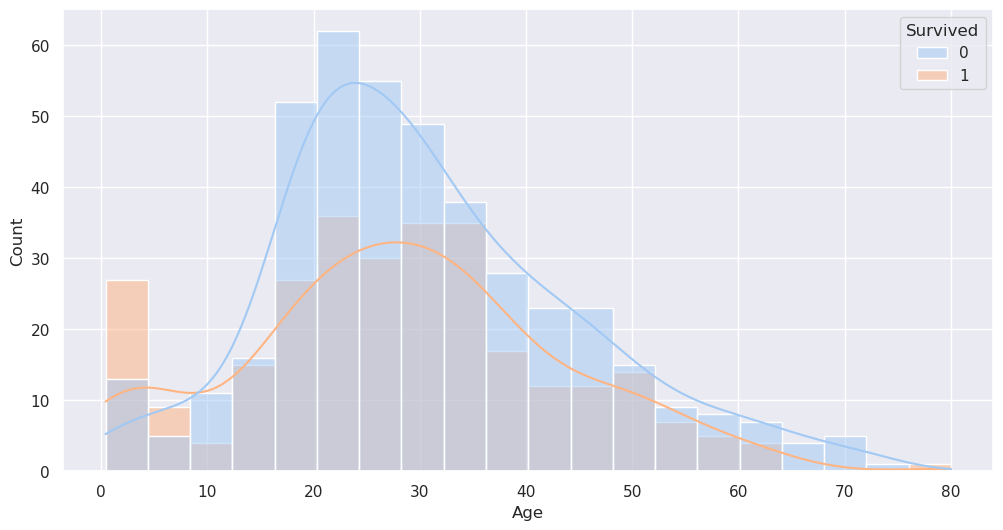

In [6]:
PLOT_SIZE = (12, 6)
sns.set_theme(palette="pastel")
plt.figure(figsize=PLOT_SIZE)
h = sns.histplot(data=train, x="Age", hue="Survived", kde=True)

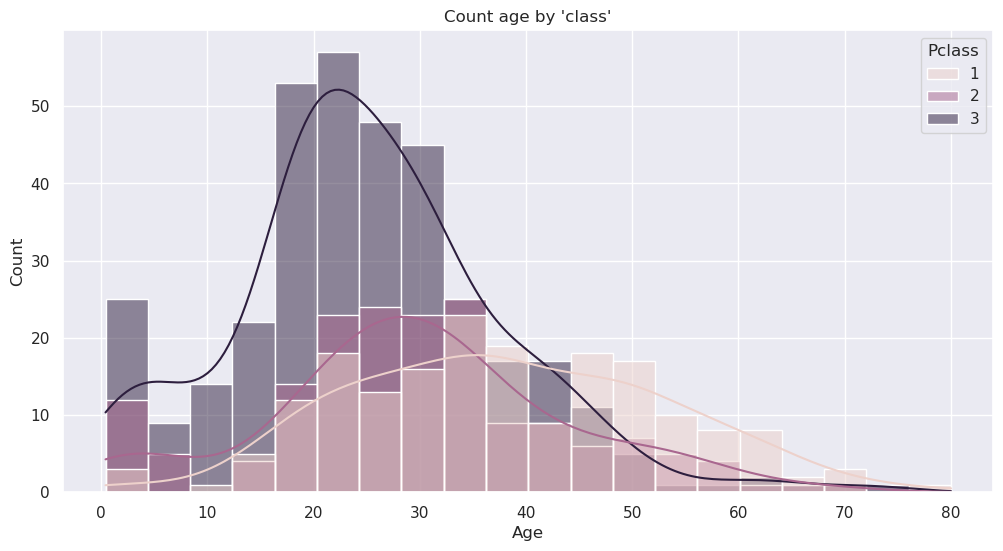

In [7]:
plt.figure(figsize=PLOT_SIZE)
h = sns.histplot(data=train, x="Age", hue="Pclass", kde=True).set_title("Count age by 'class'")

In [8]:
train.groupby(["Pclass"])["PassengerId"].agg(["count"]).rename(columns={"count":"Number"})

,Number
Pclass,
1,216
2,184
3,491


In [9]:
train.groupby(["Sex","Pclass"])["Pclass"].agg(["count"])

count
Sex    Pclass       
female 1          94
       2          76
       3         144
male   1         122
       2         108
       3         347

In [10]:
classes_grouped = train.groupby(["Pclass"])["Survived"].agg(["count", "sum"])
classes_grouped["sub"] = classes_grouped["count"] - classes_grouped["sum"]

classes_grouped.rename(columns={"count" : "All",
                                "sum" : "Survived",
                                "sub" : "Dead"})

,All,Survived,Dead
Pclass,,,
1,216,136,80
2,184,87,97
3,491,119,372


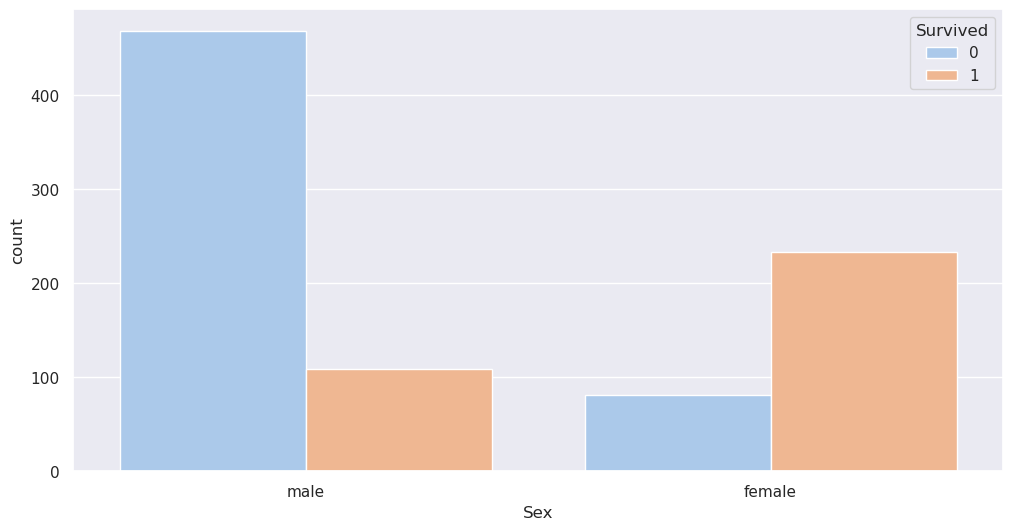

In [11]:
plt.figure(figsize=PLOT_SIZE)
c = sns.countplot(data=train, x="Sex", hue="Survived")

Predprocesiranje

In [12]:
def get_title(text):
    for word in text.split():
        if "." in word:
            return word[:-1]
        
        
train["Title"] = train["Name"].map(get_title)
train["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [13]:
grouped_titles_sum = train.groupby(["Title"])["Survived"].agg(["count", "sum"])
grouped_titles_sum["Dead"] = grouped_titles_sum["count"] - grouped_titles_sum["sum"]

grouped_titles_sum.rename(columns={"sum" : "Survived",
                                   "count" : "All"}).sort_values(by="All", ascending=False)

,All,Survived,Dead
Title,,,
Mr,517,81,436
Miss,182,127,55
Mrs,125,99,26
Master,40,23,17
Dr,7,3,4
Rev,6,0,6
Major,2,1,1
Col,2,1,1
Mlle,2,2,0


In [14]:
titles = ["Miss", "Mrs", "Mr", "Master"]
train["Title"] = train["Title"].map(lambda x: x if x in titles else "Other")

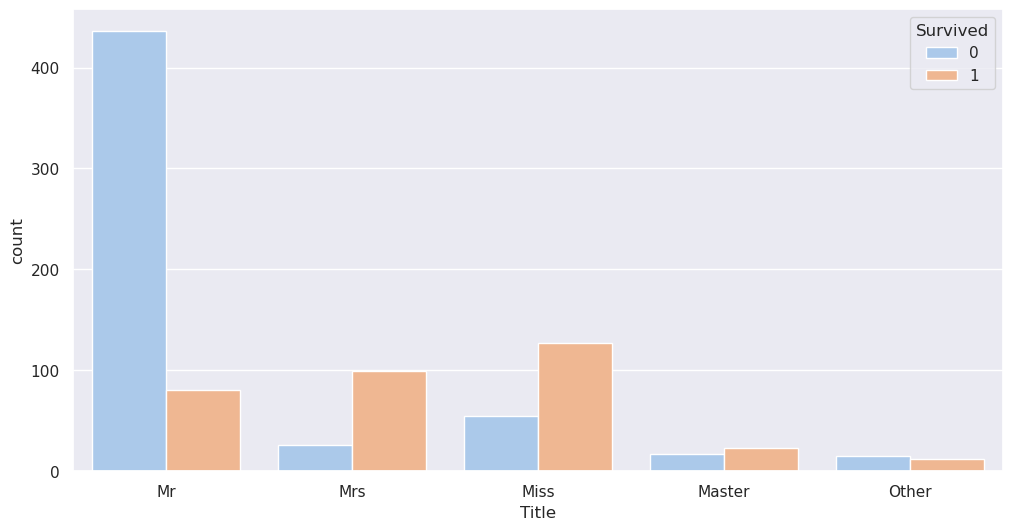

In [15]:
plt.figure(figsize=PLOT_SIZE)
c = sns.countplot(data=train, x="Title", hue="Survived")

In [16]:
# Parch == Parents and children (indicator of family members)
train["HasFamily"] = train["Parch"].map(lambda x: 1 if x != 0 else 0)
# sSibsp == Siblings and spouse (again indicates family members)
train["HasSib"] = train["SibSp"].map(lambda x: 1 if x != 0 else 0)

In [17]:
train["FarePerFamily"] = train["Fare"] / (train["Parch"]+1)
train["FarePerSib"] = train["Fare"] / (train["SibSp"]+1)

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasFamily,HasSib,FarePerFamily,FarePerSib
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,Mr,0,1,7.25,3.62
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C,Mrs,0,1,71.28,35.64
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,Miss,0,0,7.92,7.92
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,Mrs,0,1,53.10,26.55
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,Mr,0,0,8.05,8.05


In [19]:
del train["Cabin"]

In [20]:
train["Age"] = train["Age"].fillna(train["Age"].median())

In [21]:
train = train.dropna()

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,HasFamily,HasSib,FarePerFamily,FarePerSib
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,S,Mr,0,1,7.25,3.62
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C,Mrs,0,1,71.28,35.64
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,S,Miss,0,0,7.92,7.92
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,S,Mrs,0,1,53.10,26.55
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,S,Mr,0,0,8.05,8.05


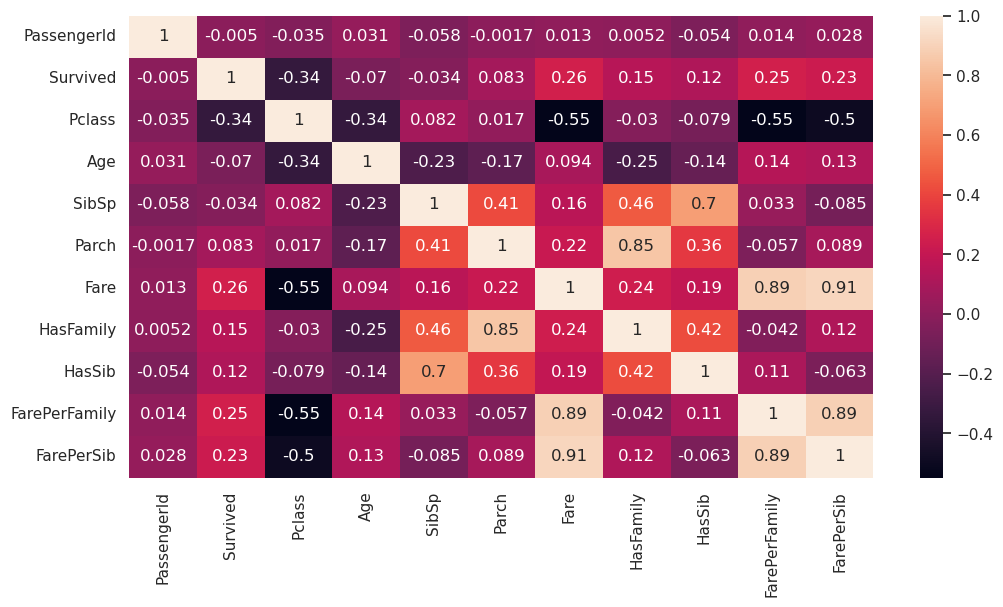

In [23]:
plt.figure(figsize=PLOT_SIZE)
h = sns.heatmap(train.corr(), annot=True)

In [24]:
lab_encoder_sex = LabelEncoder()
lab_encoder_embarked = LabelEncoder()
lab_encoder_title = LabelEncoder()
train.loc[:,"Sex"] = lab_encoder_sex.fit_transform(train["Sex"])
train.loc[:,"Embarked"] = lab_encoder_embarked.fit_transform(train["Embarked"])
train.loc[:,"Title"] = lab_encoder_title.fit_transform(train["Title"])

In [25]:
label = train["Survived"]
train = train.drop(["PassengerId", "Survived", "Name", "Ticket"], axis=1)

In [26]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,HasFamily,HasSib,FarePerFamily,FarePerSib
0,3,1,22.00,1,0,7.25,2,2,0,1,7.25,3.62
1,1,0,38.00,1,0,71.28,0,3,0,1,71.28,35.64
2,3,0,26.00,0,0,7.92,2,1,0,0,7.92,7.92
3,1,0,35.00,1,0,53.10,2,3,0,1,53.10,26.55
4,3,1,35.00,0,0,8.05,2,2,0,0,8.05,8.05


In [27]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.3)

In [28]:
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [29]:
reg = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train_s, X_test_s, y_train, y_test)

100%|██████████| 29/29 [00:01<00:00, 19.54it/s]


In [30]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.81,0.79,0.79,0.80,0.23
ExtraTreesClassifier,0.79,0.77,0.77,0.79,0.17
LogisticRegression,0.79,0.77,0.77,0.79,0.02
LGBMClassifier,0.79,0.77,0.77,0.79,0.10
NuSVC,0.79,0.77,0.77,0.79,0.03
RidgeClassifierCV,0.79,0.77,0.77,0.79,0.01
RandomForestClassifier,0.79,0.77,0.77,0.79,0.19
ExtraTreeClassifier,0.78,0.77,0.77,0.78,0.01
LinearDiscriminantAnalysis,0.78,0.76,0.76,0.78,0.03


# DNN

In [31]:
import tensorflow as tf
from tensorflow import keras

In [32]:
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),      
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

In [33]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


In [34]:
keras_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

In [35]:
hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=100)

Epoch 1/100
16/16 [==============================] - 3s 31ms/step - loss: 0.6836 - accuracy: 0.5936 - val_loss: 0.6505 - val_accuracy: 0.6800
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6263 - accuracy: 0.6559 - val_loss: 0.6052 - val_accuracy: 0.6880
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5865 - accuracy: 0.7062 - val_loss: 0.5719 - val_accuracy: 0.7360
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5480 - accuracy: 0.7807 - val_loss: 0.5353 - val_accuracy: 0.7520
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5048 - accuracy: 0.8068 - val_loss: 0.5020 - val_accuracy: 0.7840
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4687 - accuracy: 0.8229 - val_loss: 0.4731 - val_accuracy: 0.8000
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.4398 - accuracy: 0.8229 - val_loss: 0.4517 - val_accuracy: 0.8320
Epoch 8/100


<AxesSubplot:>

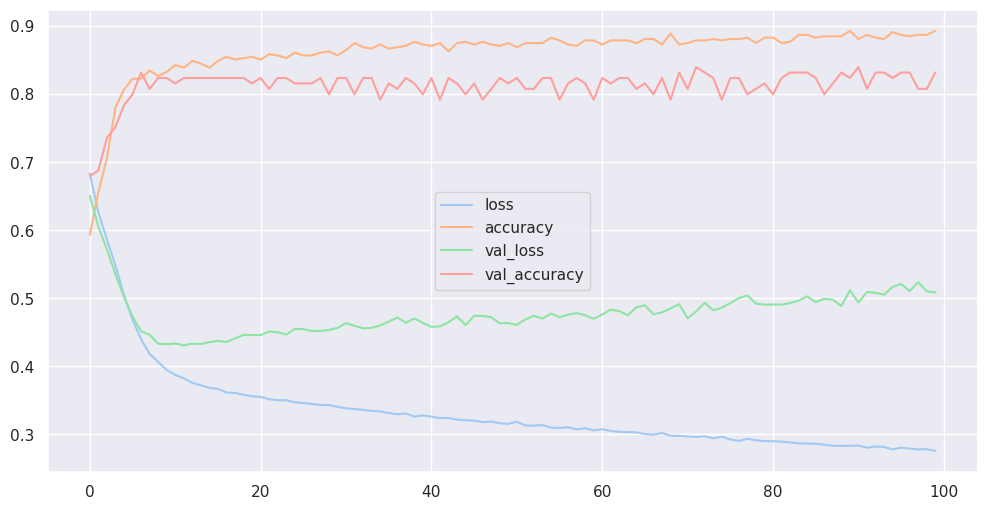

In [36]:
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

In [37]:
keras_model.evaluate(X_test_s, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 0.5920 - accuracy: 0.7640


[0.5919543504714966, 0.7640449404716492]

Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.6948 - accuracy: 0.5412 - val_loss: 0.6028 - val_accuracy: 0.7680
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6394 - accuracy: 0.6177 - val_loss: 0.5597 - val_accuracy: 0.7760
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5964 - accuracy: 0.6942 - val_loss: 0.5309 - val_accuracy: 0.7920
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5980 - accuracy: 0.7324 - val_loss: 0.5054 - val_accuracy: 0.7920
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5677 - accuracy: 0.7183 - val_loss: 0.4854 - val_accuracy: 0.8160
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5383 - accuracy: 0.7243 - val_loss: 0.4704 - val_accuracy: 0.8480
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5237 - accuracy: 0.7726 - val_loss: 0.4590 - val_accuracy: 0.8320
Epoch 8/100


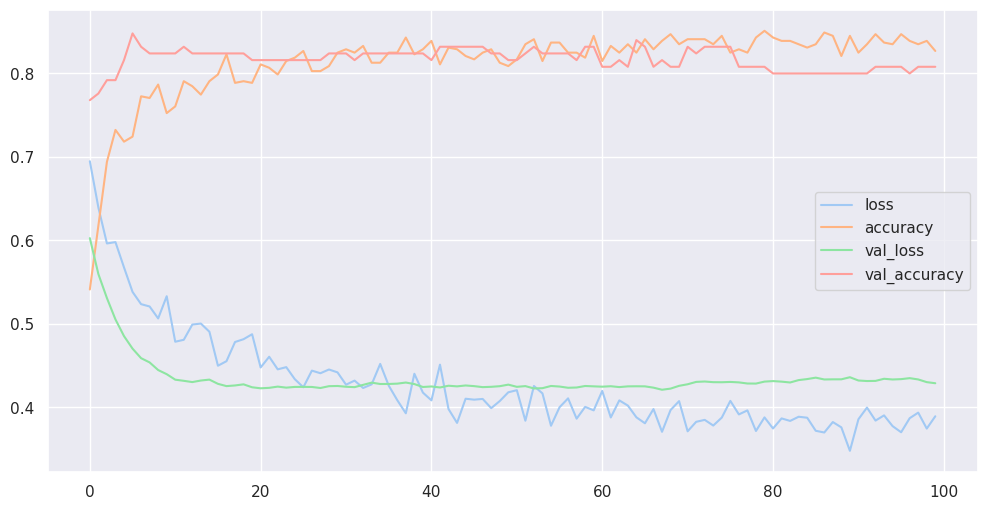

In [38]:
# Create the neural network
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, input_dim=X_train_s.shape[1], activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
hist = model.fit(X_train_s, y_train, epochs=100, batch_size=32, validation_split=0.2)

pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)
keras_model.evaluate(X_test_s, y_test)
K.clear_session()

## Overfitting

Epoch 1/500
16/16 [==============================] - 1s 14ms/step - loss: 0.6740 - accuracy: 0.5895 - val_loss: 0.6206 - val_accuracy: 0.7200
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.6173 - accuracy: 0.7123 - val_loss: 0.5653 - val_accuracy: 0.7600
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.5776 - accuracy: 0.7465 - val_loss: 0.5245 - val_accuracy: 0.7760
Epoch 4/500
16/16 [==============================] - 0s 6ms/step - loss: 0.5421 - accuracy: 0.7606 - val_loss: 0.4886 - val_accuracy: 0.8000
Epoch 5/500
16/16 [==============================] - 0s 6ms/step - loss: 0.5126 - accuracy: 0.7787 - val_loss: 0.4629 - val_accuracy: 0.8320
Epoch 6/500
16/16 [==============================] - 0s 6ms/step - loss: 0.4906 - accuracy: 0.8028 - val_loss: 0.4456 - val_accuracy: 0.8560
Epoch 7/500
16/16 [==============================] - 0s 6ms/step - loss: 0.4733 - accuracy: 0.8028 - val_loss: 0.4332 - val_accuracy: 0.8640
Epoch 8/500


<AxesSubplot:>

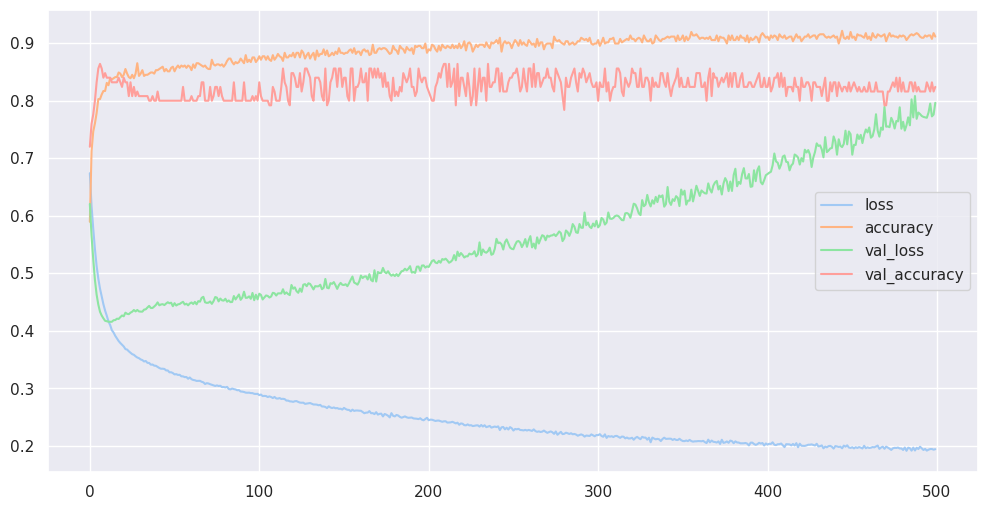

In [39]:
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),     
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

keras_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=500)
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

## Custom loss fucntion

loss = -(y_true * log(y_pred) + (1-y_true) * log(1-y_pred)).

### custom_loss_binary

Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.6538 - accuracy: 0.6298 - val_loss: 0.5792 - val_accuracy: 0.7200
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6052 - accuracy: 0.6740 - val_loss: 0.5366 - val_accuracy: 0.7520
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5740 - accuracy: 0.7123 - val_loss: 0.5091 - val_accuracy: 0.7600
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5495 - accuracy: 0.7344 - val_loss: 0.4861 - val_accuracy: 0.7920
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5291 - accuracy: 0.7465 - val_loss: 0.4694 - val_accuracy: 0.8160
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5101 - accuracy: 0.7626 - val_loss: 0.4545 - val_accuracy: 0.7920
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.4936 - accuracy: 0.7807 - val_loss: 0.4457 - val_accuracy: 0.8160
Epoch 8/100


[0.6028172373771667, 0.7303370833396912]

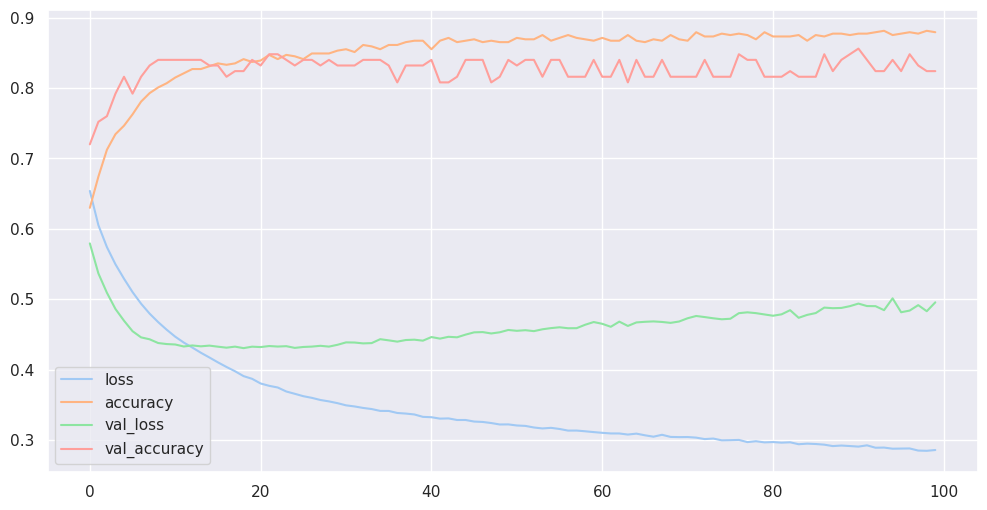

In [40]:
def calculate_binary_coef(y_true, y_pred):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    left = y_true * K.log(y_pred)
    right = (1-y_true) *  K.log(1-y_pred)
    return -(left + right)

    #return -K.mean(K.sum(y_true* K.log(y_pred)))

def custom_loss_binary():
    def binary(y_true, y_pred):
        return calculate_binary_coef(y_true, y_pred)
    return binary

K.clear_session()
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),      
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

keras_model.compile(
        optimizer= tf.keras.optimizers.RMSprop(),
        loss= custom_loss_binary(),
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=100)
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

keras_model.evaluate(X_test_s, y_test)

### Na osnovu zastupljenosti prezivelih i ne
Pokazalo se da ne radi

In [41]:
# Na osnovu zastupljenosti prezivelih i ne
def my_loss(y_true, y_pred):
            
    loss = K.abs(float(y_pred) - float(y_true))
    loss = loss *[0.38, 0.62]
    loss = K.sum(loss, axis=1)   
    return loss

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 0.4809 - accuracy: 0.6499 - val_loss: 0.4790 - val_accuracy: 0.7200
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.4611 - accuracy: 0.7143 - val_loss: 0.4630 - val_accuracy: 0.7200
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4420 - accuracy: 0.7183 - val_loss: 0.4437 - val_accuracy: 0.7440
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4191 - accuracy: 0.7324 - val_loss: 0.4192 - val_accuracy: 0.7600
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3942 - accuracy: 0.7586 - val_loss: 0.3929 - val_accuracy: 0.7680
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.3670 - accuracy: 0.7767 - val_loss: 0.3644 - val_accuracy: 0.8160
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3378 - accuracy: 0.7948 - val_loss: 0.3334 - val_accuracy: 0.8000
Epoch 8/100


[0.20749792456626892, 0.7977527976036072]

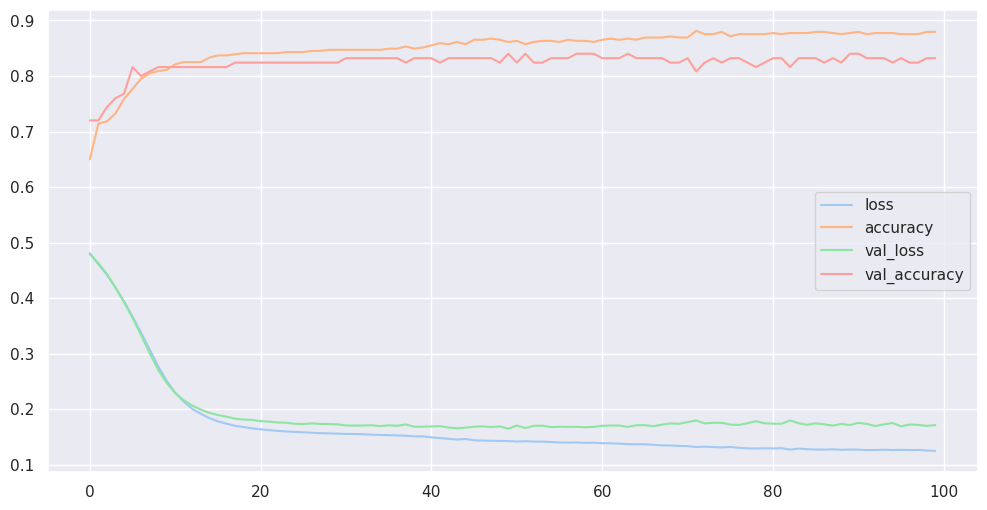

In [42]:
def my_loss(y_true, y_pred):
            
    loss = K.abs(float(y_pred) - float(y_true))
    loss = loss *[0.38, 0.62]
    loss = K.sum(loss, axis=1)   
    return loss

K.clear_session()
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),      
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

keras_model.compile(
        optimizer= tf.keras.optimizers.RMSprop(),
        loss= my_loss,
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=100)
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

keras_model.evaluate(X_test_s, y_test)

### weighted_binary_crossentropy

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 0.6752 - accuracy: 0.5855 - val_loss: 0.6394 - val_accuracy: 0.7280
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6274 - accuracy: 0.6821 - val_loss: 0.5956 - val_accuracy: 0.7600
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5921 - accuracy: 0.7324 - val_loss: 0.5561 - val_accuracy: 0.7840
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5633 - accuracy: 0.7384 - val_loss: 0.5252 - val_accuracy: 0.7920
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5396 - accuracy: 0.7586 - val_loss: 0.5027 - val_accuracy: 0.7760
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5195 - accuracy: 0.7686 - val_loss: 0.4811 - val_accuracy: 0.8080
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5003 - accuracy: 0.7847 - val_loss: 0.4636 - val_accuracy: 0.8080
Epoch 8/100


[0.5888683199882507, 0.7715355753898621]

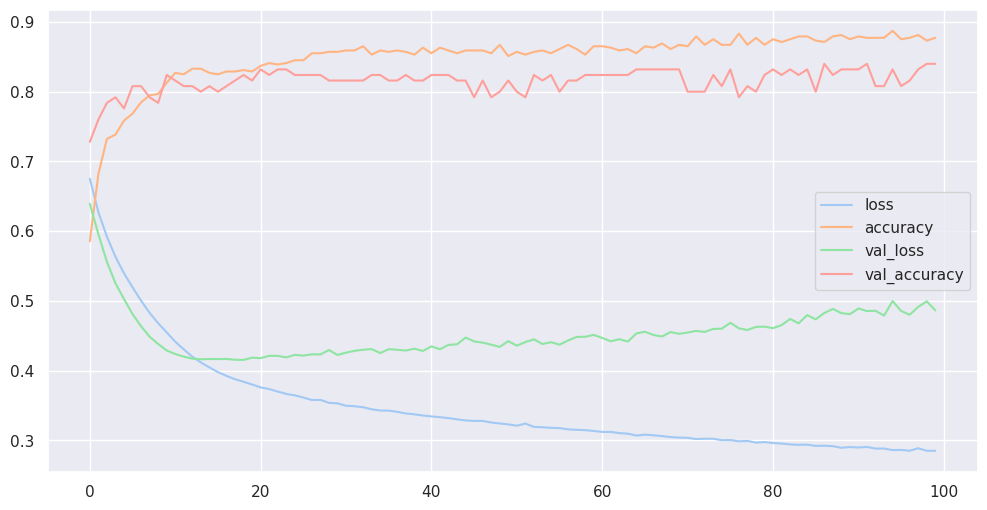

In [43]:
# OK
def weighted_binary_crossentropy(pos_weight=1):
    def weighted_binary_crossentropy_fixed(y_true, y_pred):
        # Calculate binary crossentropy
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        
        # Apply the weights
        weight_vector = y_true * pos_weight + (1. - y_true)
        weighted_bce = weight_vector * bce
        
        # Calculate the mean over all samples
        return K.mean(weighted_bce)
    
    return weighted_binary_crossentropy_fixed


K.clear_session()
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),      
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

keras_model.compile(
        optimizer= tf.keras.optimizers.RMSprop(),
        loss= weighted_binary_crossentropy(),
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=100)
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

keras_model.evaluate(X_test_s, y_test)




### jaccard_loss

Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.7075 - accuracy: 0.3984 - val_loss: 0.7153 - val_accuracy: 0.3760
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6672 - accuracy: 0.4245 - val_loss: 0.6880 - val_accuracy: 0.3440
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6351 - accuracy: 0.4004 - val_loss: 0.6619 - val_accuracy: 0.3440
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6057 - accuracy: 0.4326 - val_loss: 0.6374 - val_accuracy: 0.4880
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5810 - accuracy: 0.5956 - val_loss: 0.6128 - val_accuracy: 0.5840
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5508 - accuracy: 0.6700 - val_loss: 0.5832 - val_accuracy: 0.7040
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.5202 - accuracy: 0.7183 - val_loss: 0.5468 - val_accuracy: 0.7520
Epoch 8/100


[0.4647369980812073, 0.7453183531761169]

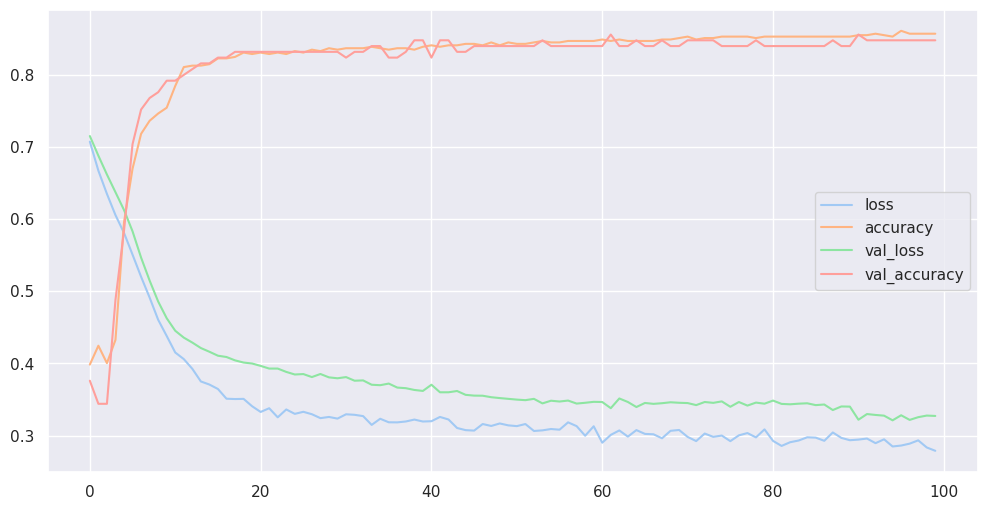

In [44]:

def jaccard_loss(y_true, y_pred, smooth=1e-7):
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # Flatten the inputs
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Calculate the intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    # Calculate the Jaccard similarity
    jaccard = (intersection + smooth) / (union + smooth)
    
    # Convert Jaccard similarity to a loss
    loss = 1. - jaccard
    
    return loss

K.clear_session()
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),      
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

keras_model.compile(
        optimizer= tf.keras.optimizers.RMSprop(),
        loss= jaccard_loss,
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=100)
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)

keras_model.evaluate(X_test_s, y_test)

### contrastive_loss

Epoch 1/100
16/16 [==============================] - 1s 14ms/step - loss: 0.2251 - accuracy: 0.3823 - val_loss: 0.2008 - val_accuracy: 0.2960
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1919 - accuracy: 0.2495 - val_loss: 0.1759 - val_accuracy: 0.2480
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1724 - accuracy: 0.2173 - val_loss: 0.1618 - val_accuracy: 0.2080
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.1588 - accuracy: 0.2093 - val_loss: 0.1520 - val_accuracy: 0.2080
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1496 - accuracy: 0.2012 - val_loss: 0.1452 - val_accuracy: 0.2320
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1425 - accuracy: 0.1851 - val_loss: 0.1412 - val_accuracy: 0.2160
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1369 - accuracy: 0.1771 - val_loss: 0.1370 - val_accuracy: 0.1760
Epoch 8/100


<AxesSubplot:>

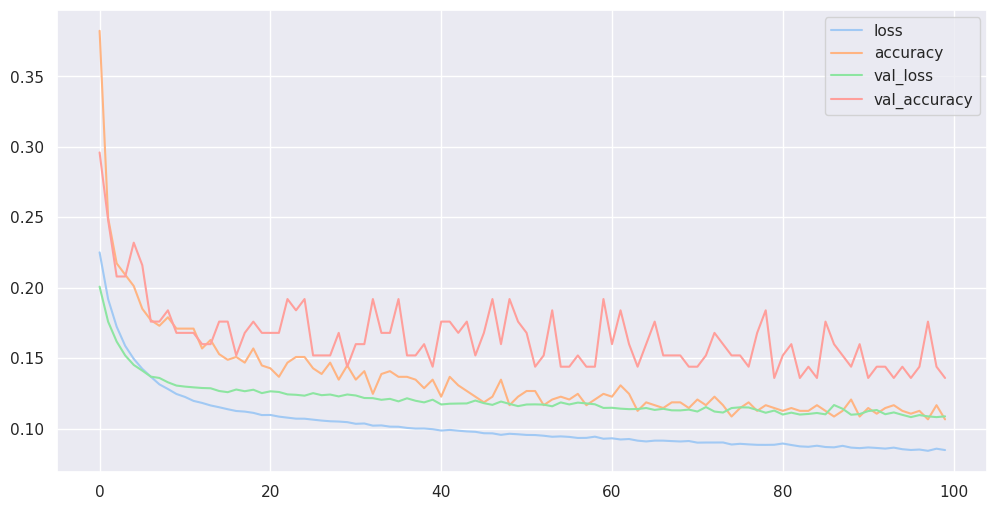

In [45]:
K.clear_session()


from tensorflow.keras import backend as K


# NE
def contrastive_loss(y_true, y_pred, margin=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    loss = tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

K.clear_session()
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),      
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

keras_model.compile(
        optimizer= tf.keras.optimizers.RMSprop(),
        loss= contrastive_loss,
        metrics=["accuracy"]
    )

hist = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=100)
pd.DataFrame(hist.history).plot(figsize=PLOT_SIZE)


# Optimizers 

Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.7115 - accuracy: 0.5654 - val_loss: 0.7013 - val_accuracy: 0.6240
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7114 - accuracy: 0.5654 - val_loss: 0.7013 - val_accuracy: 0.6240
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7114 - accuracy: 0.5654 - val_loss: 0.7012 - val_accuracy: 0.6240
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7113 - accuracy: 0.5674 - val_loss: 0.7012 - val_accuracy: 0.6240
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7113 - accuracy: 0.5674 - val_loss: 0.7011 - val_accuracy: 0.6240
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7112 - accuracy: 0.5674 - val_loss: 0.7011 - val_accuracy: 0.6240
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7111 - accuracy: 0.5674 - val_loss: 0.7010 - val_accuracy: 0.6240
Epoch 8/100


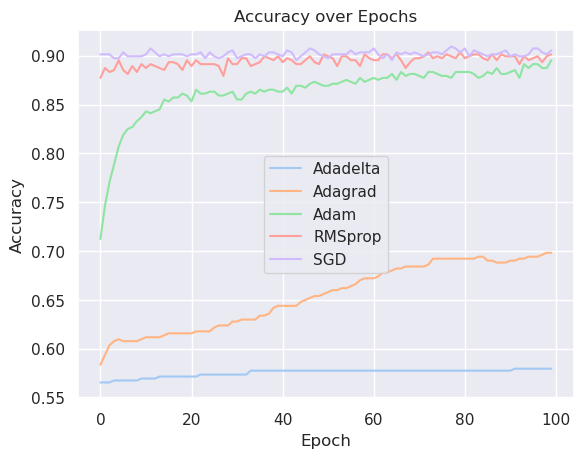

In [46]:
keras_model = keras.models.Sequential([
    
    keras.layers.Input(shape=[12]),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),      
    keras.layers.Dense(8, activation="relu"),     
    keras.layers.Dense(1, activation="sigmoid")
])

# optimizer_names = ['SGD', 'Adam', 'RMSprop']
optimizer_names = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']
# optimizers = [sgd, adam, rmsprop]
history_dict = {}


for optimizer_name in optimizer_names:
#     optimizer = eval(optimizer_name.lower())
    keras_model.compile(loss='binary_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])
    history = keras_model.fit(X_train_s, y_train, 
                       validation_split=0.2,
                       epochs=100)
    history_dict[optimizer_name] = history.history

# # df = pd.DataFrame(columns=['Epoch', 'SGD Accuracy', 'Adam Accuracy', 'RMSprop Accuracy'])
# df = pd.DataFrame(columns=['Epoch','Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'])

# for epoch in range(1, 100,10):
#     row_data = {'Epoch': epoch}
#     for optimizer_name, history in history_dict.items():
#         row_data[optimizer_name + ' Accuracy'] = history['accuracy'][epoch-1]
#     df = df.append(row_data, ignore_index=True)

# print(df)


# Create a plot comparing the performance of each optimizer over epochs
for optimizer_name, history in history_dict.items():
    plt.plot(history['accuracy'], label=optimizer_name)

plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()